# UIDAI Hackathon: Unlocking Societal Trends in Aadhaar Enrolment and Updates

This notebook prepares the analysis for the consolidated PDF:
- Problem Statement & Approach
- Datasets Used
- Methodology (cleaning, preprocessing, transformations)
- Data Analysis, Visualizations, Key Insights

Update the file paths below and run cells sequentially.

In [1]:
!pip install -q pandas numpy seaborn plotly scikit-learn statsmodels

In [1]:
# Imports and global setup
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from functools import reduce
import warnings; warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

## Problem Statement & Approach

**Goal:** Identify patterns, trends, anomalies, and predictive indicators in Aadhaar enrolments and updates to support decisions and system improvements.

**Approach:**
1. Standardize and clean all datasets.
2. Aggregate by time (monthly) and geography (state; extend to district/PIN as needed).
3. Derive comparable metrics (e.g., update rate per 1k enrolments).
4. Visualize trends and detect anomalies (rolling z-scores).
5. Build a simple baseline forecast for enrolments.
6. Export key tables for the PDF.

## Datasets Used
- Aadhaar Enrolment dataset (date, state, district, PIN, age buckets, counts).
- Aadhaar Demographic Update dataset (date, state/district/PIN, update types).
- Aadhaar Biometric Update dataset (date, state/district/PIN, modalities).

Specify the CSV file paths below.

In [5]:
# Configure dataset file paths (TODO: update paths to your local files)
ENROL_PATH = r'.\datasets\api_data_aadhar_enrolment\api_data_aadhar_enrolment_0_500000.csv'  # TODO
DEMO_PATH  = r'.\datasets\api_data_aadhar_demographic\api_data_aadhar_demographic_0_500000.csv'  # TODO
BIO_PATH   = r'.\datasets\api_data_aadhar_biometric\api_data_aadhar_biometric_0_500000.csv'  # TODO

# Optional: folder to save outputs
OUTPUT_DIR = r'.\outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Methodology: Cleaning, Preprocessing, Transformations
Standardize columns, parse dates, clean geographies, and build monthly aggregates.

In [6]:
# Helper functions
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    rename_map = {
        'state_name': 'state', 'statecode': 'state', 'state_code': 'state',
        'district_name': 'district', 'districtcode': 'district', 'district_code': 'district',
        'pincode': 'pin', 'pin_code': 'pin', 'pincode_number': 'pin',
        'date_of_enrolment': 'date', 'enrolment_date': 'date', 'txn_date': 'date', 'transaction_date': 'date'
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
    return df

def parse_date(df: pd.DataFrame, col: str = 'date') -> pd.DataFrame:
    df = df.copy()
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df['year'] = df[col].dt.year
        df['month'] = df[col].dt.month
        df['year_month'] = df[col].dt.to_period('M').dt.to_timestamp()
    return df

def clean_geo(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if 'pin' in df.columns:
        df['pin'] = pd.to_numeric(df['pin'], errors='coerce').astype('Int64')
    for c in ['state', 'district']:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().str.title()
    return df

def summarize_missing(df: pd.DataFrame, name: str = 'df') -> pd.Series:
    miss = df.isna().mean().sort_values(ascending=False)
    print(f"{name}: rows={len(df):,}, cols={df.shape[1]}")
    return miss.head(20)

In [7]:
# Load datasets
enrol = pd.read_csv(ENROL_PATH)
demo  = pd.read_csv(DEMO_PATH)
bio   = pd.read_csv(BIO_PATH)

# Standardize schema and parse
enrol = clean_geo(parse_date(standardize_columns(enrol)))
demo  = clean_geo(parse_date(standardize_columns(demo)))
bio   = clean_geo(parse_date(standardize_columns(bio)))

# Quick checks
display(enrol.head(3))
display(demo.head(3))
display(bio.head(3))
print('Missing (enrol):\n', summarize_missing(enrol, 'enrol'))

,date,state,district,pin,age_0_5,age_5_17,age_18_greater,year,month,year_month
0,2025-02-03,Meghalaya,East Khasi Hills,793121,11,61,37,2025.0,2.0,2025-02-01
1,2025-09-03,Karnataka,Bengaluru Urban,560043,14,33,39,2025.0,9.0,2025-09-01
2,2025-09-03,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,2025.0,9.0,2025-09-01


,date,state,district,pin,demo_age_5_17,demo_age_17_,year,month,year_month
0,2025-01-03,Uttar Pradesh,Gorakhpur,273213,49,529,2025.0,1.0,2025-01-01
1,2025-01-03,Andhra Pradesh,Chittoor,517132,22,375,2025.0,1.0,2025-01-01
2,2025-01-03,Gujarat,Rajkot,360006,65,765,2025.0,1.0,2025-01-01


,date,state,district,pin,bio_age_5_17,bio_age_17_,year,month,year_month
0,2025-01-03,Haryana,Mahendragarh,123029,280,577,2025.0,1.0,2025-01-01
1,2025-01-03,Bihar,Madhepura,852121,144,369,2025.0,1.0,2025-01-01
2,2025-01-03,Jammu And Kashmir,Punch,185101,643,1091,2025.0,1.0,2025-01-01


enrol: rows=500,000, cols=10
Missing (enrol):
 date              0.65414
month             0.65414
year              0.65414
year_month        0.65414
state             0.00000
district          0.00000
age_5_17          0.00000
age_0_5           0.00000
pin               0.00000
age_18_greater    0.00000
dtype: float64


In [8]:
# Derived metrics and harmonization
# Ensure an enrolment count column
if 'count' not in enrol.columns:
    for c in ['enrolments', 'enrolment_count', 'enrolment', 'total_enrolments', 'no_of_enrolments']:
        if c in enrol.columns:
            enrol = enrol.rename(columns={c: 'count'})
            break
enrol['count'] = pd.to_numeric(enrol.get('count', pd.Series(np.ones(len(enrol)))), errors='coerce').fillna(1).astype(int)

# Age buckets (optional, if provided)
for c in [c for c in enrol.columns if any(x in c for x in ['0_5', '0-5', '5_17', '5-17', '18_plus', '18+'])]:
    enrol[c] = pd.to_numeric(enrol[c], errors='coerce').fillna(0).astype(int)

# Normalize update type if present
if 'update_type' in demo.columns:
    demo['update_type'] = demo['update_type'].astype(str).str.lower().str.replace(' ', '_')

# Build monthly aggregates (state level)
enr_m = enrol.groupby(['year_month', 'state'], as_index=False)['count'].sum().rename(columns={'count': 'enrol_count'})
dem_m = demo.groupby(['year_month', 'state'], as_index=False).size().rename(columns={'size': 'demo_updates'}) if 'year_month' in demo.columns else pd.DataFrame()
bio_m = bio.groupby(['year_month', 'state'], as_index=False).size().rename(columns={'size': 'bio_updates'}) if 'year_month' in bio.columns else pd.DataFrame()

# Join monthly metrics
dfs = [d for d in [enr_m, dem_m, bio_m] if not d.empty]
monthly = reduce(lambda l, r: pd.merge(l, r, on=['year_month', 'state'], how='outer'), dfs) if dfs else pd.DataFrame()
monthly = monthly.sort_values(['state', 'year_month']).fillna(0)
if not monthly.empty:
    monthly['update_rate_per_1k_enrol'] = np.where(monthly['enrol_count'] > 0,
                                                   1000 * (monthly.get('demo_updates', 0) + monthly.get('bio_updates', 0)) / monthly['enrol_count'],
                                                   np.nan)
monthly.head()

,year_month,state,enrol_count,demo_updates,bio_updates,update_rate_per_1k_enrol
48,2025-02-01,100000,1.0,0.0,0.0,0.0
95,2025-03-01,100000,1.0,0.0,0.0,0.0
328,2025-08-01,100000,1.0,0.0,0.0,0.0
376,2025-09-01,100000,1.0,0.0,0.0,0.0
468,2025-11-01,100000,1.0,0.0,0.0,0.0


## Data Analysis & Visualisation
Trend lines and comparative charts by state and month.

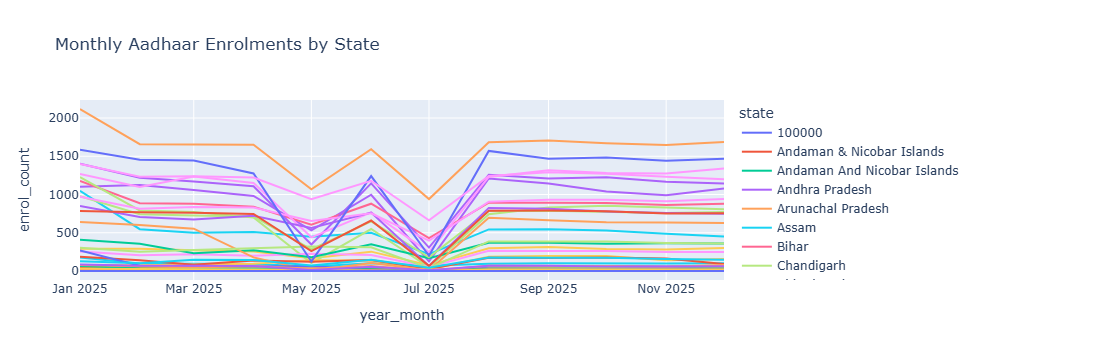

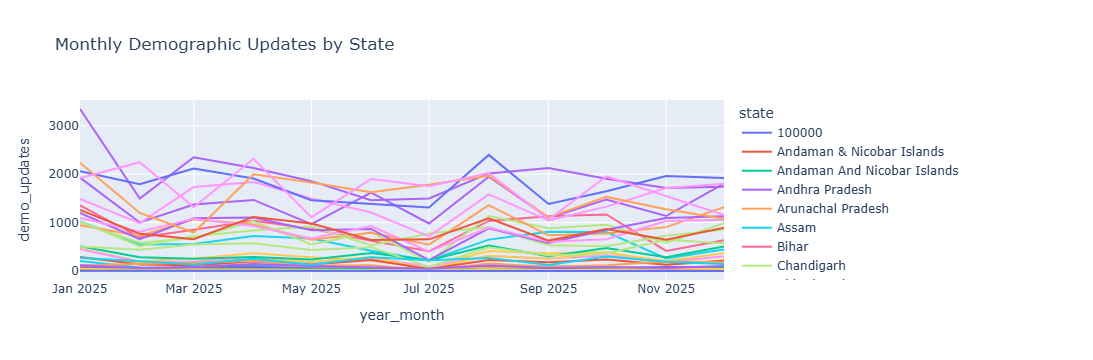

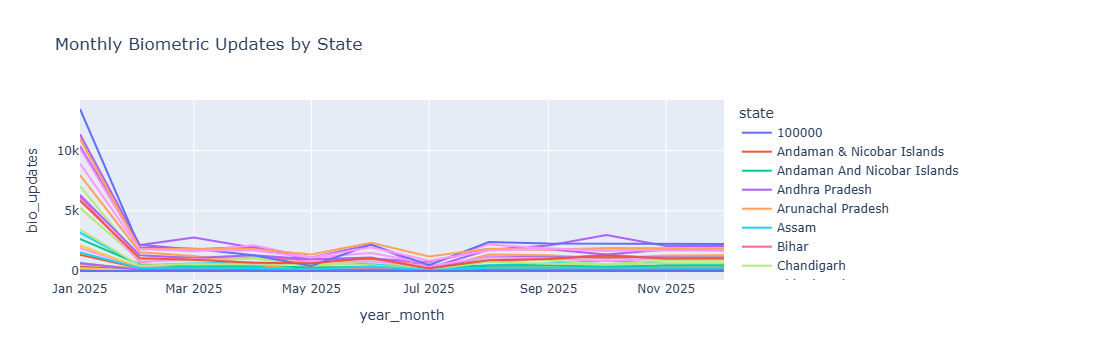

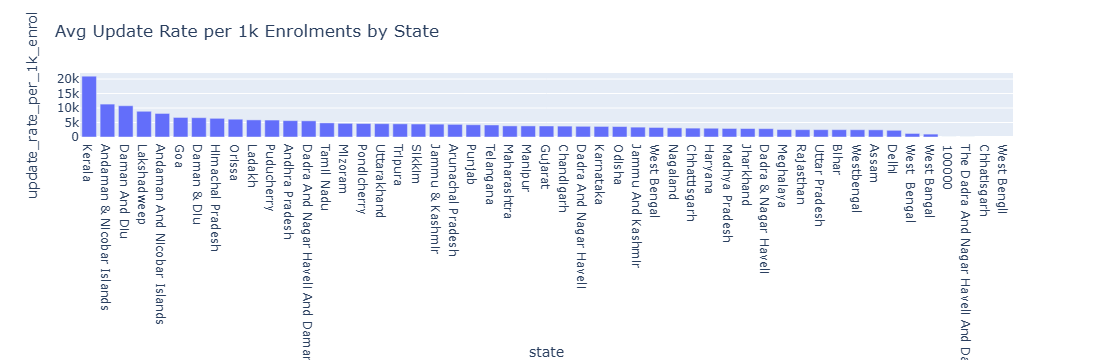

In [9]:
# Time-series visualizations
assert not monthly.empty, 'Monthly aggregation is empty. Check file paths and column mappings.'
fig1 = px.line(monthly, x='year_month', y='enrol_count', color='state', title='Monthly Aadhaar Enrolments by State')
fig1.show()

if 'demo_updates' in monthly.columns:
    fig2 = px.line(monthly, x='year_month', y='demo_updates', color='state', title='Monthly Demographic Updates by State')
    fig2.show()

if 'bio_updates' in monthly.columns:
    fig3 = px.line(monthly, x='year_month', y='bio_updates', color='state', title='Monthly Biometric Updates by State')
    fig3.show()

if 'update_rate_per_1k_enrol' in monthly.columns:
    avg_rate = monthly.groupby('state')['update_rate_per_1k_enrol'].mean().sort_values(ascending=False)
    order = avg_rate.index.tolist()
    fig4 = px.bar(monthly.groupby('state', as_index=False)['update_rate_per_1k_enrol'].mean(),
                  x='state', y='update_rate_per_1k_enrol',
                  title='Avg Update Rate per 1k Enrolments by State')
    fig4.update_xaxes(categoryorder='array', categoryarray=order)
    fig4.show()

## Anomaly Detection
Rolling z-score on monthly series to flag spikes/dips.

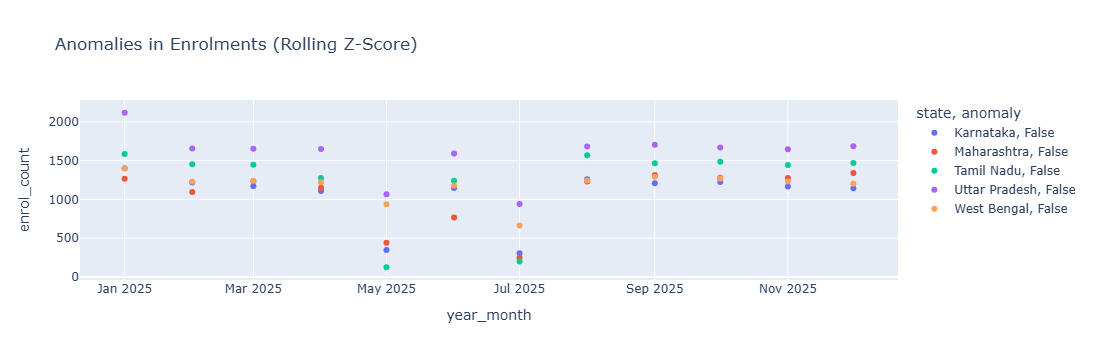

In [10]:
# Rolling z-score anomaly detection
def mark_anomalies(df: pd.DataFrame, value_col: str, group_col: str = 'state', window: int = 6, z: float = 2.5) -> pd.DataFrame:
    out = []
    for g, sub in df.sort_values('year_month').groupby(group_col):
        s = sub[['year_month', value_col]].copy()
        s['roll_mean'] = s[value_col].rolling(window, min_periods=3).mean()
        s['roll_std']  = s[value_col].rolling(window, min_periods=3).std(ddof=0)
        s['z'] = (s[value_col] - s['roll_mean']) / s['roll_std']
        s[group_col] = g
        out.append(s)
    out = pd.concat(out, ignore_index=True)
    out['anomaly'] = out['z'].abs() >= z
    return out

an_enrol = mark_anomalies(monthly, 'enrol_count')
an_demo  = mark_anomalies(monthly, 'demo_updates') if 'demo_updates' in monthly.columns else pd.DataFrame()

# Visualize anomalies for top-5 states by volume
top_states = monthly.groupby('state')['enrol_count'].sum().nlargest(5).index
sub = monthly.merge(an_enrol[['year_month','state','z','anomaly']], on=['year_month','state'])
sub = sub[sub['state'].isin(top_states)]
fig = px.scatter(sub, x='year_month', y='enrol_count', color='state',
                 symbol='anomaly', symbol_map={True:'x', False:'circle'},
                 title='Anomalies in Enrolments (Rolling Z-Score)')
fig.show()

## Predictive Baseline
Seasonal-naive forecast (12-month season) as a simple baseline.

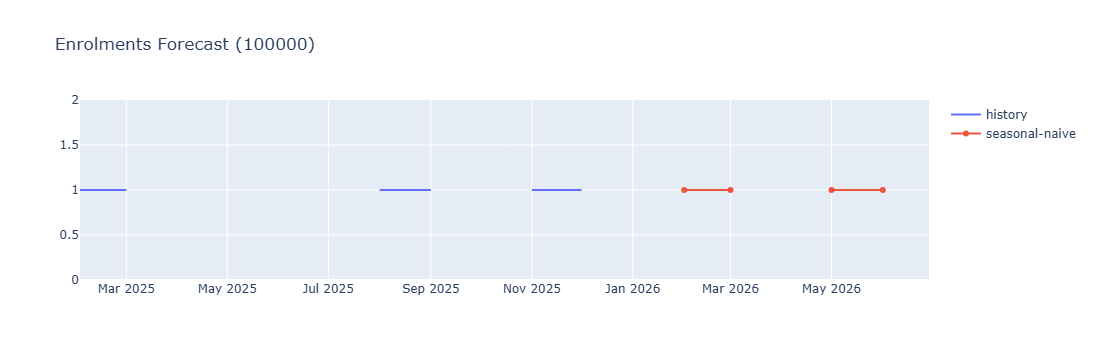

In [11]:
# Seasonal-naive forecast for a selected state
if len(monthly):
    cand = monthly['state'].dropna().unique().tolist()
    STATE = cand[0] if cand else None
else:
    STATE = None

if STATE is not None:
    ts = monthly[monthly['state'] == STATE].set_index('year_month')['enrol_count'].asfreq('MS')
    season = 12
    horizon = 6
    if len(ts) == 0:
        raise ValueError('No data for selected state')
    last_season = ts.iloc[-season:] if len(ts) >= season else ts.iloc[-min(3, len(ts)):]
    fcst_index = pd.date_range(ts.index.max() + pd.offsets.MonthBegin(1), periods=horizon, freq='MS')
    fcst_vals = np.resize(last_season.values, horizon)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ts.index, y=ts.values, mode='lines', name='history'))
    fig.add_trace(go.Scatter(x=fcst_index, y=fcst_vals, mode='lines+markers', name='seasonal-naive'))
    fig.update_layout(title=f'Enrolments Forecast ({STATE})')
    fig.show()

## Export
Save summary tables for inclusion in the PDF.

In [12]:
# Save outputs
monthly.to_csv(os.path.join(OUTPUT_DIR, 'monthly_metrics.csv'), index=False)
if 'an_enrol' in locals() and isinstance(an_enrol, pd.DataFrame) and not an_enrol.empty:
    an_enrol.to_csv(os.path.join(OUTPUT_DIR, 'anomalies_enrol.csv'), index=False)
print('Saved outputs to', OUTPUT_DIR)

Saved outputs to .\outputs


## Notes & Next Steps
- Refine column mappings once exact headers are confirmed.
- Extend aggregations to district and PIN where needed.
- Add domain features (school calendar, elections, policy events) if allowed.
- For the PDF, export this notebook or copy markdown/code outputs.